In [2]:
import numpy as np
import pandas as pd
import os
import pdb
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42

In [3]:
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
enformer_data_dir = "/global/scratch/users/aniketh/enformer_data/"
root_save_dir = "/global/scratch/users/aniketh/finetune-enformer/"
models_dir = "/global/scratch/users/aniketh/finetune-enformer/saved_models/"
test_preds_dir = "/global/scratch/users/aniketh/finetune-enformer/test_preds_final/"
rest_unseen_preds_dir = (
    "/global/scratch/users/aniketh/finetune-enformer/rest_unseen_preds_final/"
)
enformer_test_data_preds_dir = (
    "/global/scratch/users/aniketh/finetune-enformer/enformer_test_data_preds_final/"
)
ISM_preds_dir = "/global/scratch/users/aniketh/finetune-enformer/ISM/"
code_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer"
fasta_path = "/clusterfs/nilah/aniketh/hg19/hg19.fa"
malinois_data_path = (
    "/clusterfs/nilah/aniketh/Malinois/all_sequences_variant_effect_data.csv"
)

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")
rest_unseen_h5_path = os.path.join(data_dir, "rest_unseen.h5")

counts_path = os.path.join(
    code_dir, "process_geuvadis_data", "log_tpm", "corrected_log_tpm.annot.csv.gz"
)
gene_class_path = os.path.join(
    code_dir, "finetuning", "data", "h5_bins_384_chrom_split", "gene_class.csv"
)

assert os.path.exists(counts_path) and os.path.exists(gene_class_path)

In [4]:
all_main_run_names = {
    "baseline": "",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "finetune_regression_on_enformer_data": "NCCL_P2P_DISABLE=1 python finetuning/finetune_pairwise_regression_model_on_Enformer_training_data.py {enformer_data_dir} {run_name} {models_dir} {base_run_name} --batch_size 4 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
}

all_seeds = [42, 97]
all_gaussian_noise_std_multipliers = [0.3, 0.5, 1.0]
subsample_fracs = [0.2, 0.4, 0.6, 0.8]
all_afs = (
    list(np.arange(0.01, 0.1, 0.01).round(2))
    + list(np.arange(0.1, 0.4, 0.05).round(2))
    + list(np.arange(0.41, 0.49, 0.01).round(2))
)
print(all_afs)
afs_cache_path = os.path.join(root_save_dir, "train.h5.afs.pkl")

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49]


In [5]:
full_summary = []

def load_summary_df(
    preds_dir,
    model_name,
    run_name,
    species,
    seed,
    fname = "summary_df.csv"
):
    fpath = os.path.join(preds_dir, model_name, species, fname)
    summary_df = pd.read_csv(fpath)
    summary_df["model"] = run_name
    summary_df["seed"] = seed
    summary_df["species"] = species
    summary_df["track_id"] = summary_df["species"] + "_" + summary_df.index.astype(str)
    return summary_df
    
for run in [
    "baseline",
    "regression",
    "joint_regression",
    "finetune_regression_on_enformer_data",
]:
    for species in ["human", "mouse"]:
        if run == "baseline":
            summary_df = load_summary_df(enformer_test_data_preds_dir, run, run, species, 0)
            full_summary.append(summary_df)
        else:
            for i, seed in enumerate(all_seeds):
                train_cmd_template = all_main_run_names[run]
                lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(
                    " "
                )[0]
                wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                    -1
                ].split(" ")[0]
                rcprob_used_during_training = 0.5
                rsmax_used_during_training = 3

                model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
                if "random_init" in run:
                    model_name = model_name + "_random_init"
                summary_df = load_summary_df(enformer_test_data_preds_dir, model_name, run, species, seed)
                full_summary.append(summary_df)

full_summary = pd.concat(full_summary).reset_index(drop=True)
full_summary

,track_name,pearson_corr,spearman_corr,r2_score,model,seed,species,track_id
0,DNASE:cerebellum male adult (27 years) and mal...,0.850465,0.837940,0.716890,baseline,0,human,human_0
1,DNASE:frontal cortex male adult (27 years) and...,0.880195,0.835683,0.765466,baseline,0,human,human_1
2,DNASE:chorion,0.826891,0.703724,0.678859,baseline,0,human,human_2
3,DNASE:Ishikawa treated with 0.02% dimethyl sul...,0.811891,0.788419,0.656670,baseline,0,human,human_3
4,DNASE:GM03348,0.865890,0.830272,0.747668,baseline,0,human,human_4
...,...,...,...,...,...,...,...,...
48687,"CAGE:natural helper cells, naive, biol_, tech_...",0.488297,0.110570,0.205508,finetune_regression_on_enformer_data,97,mouse,mouse_1638
48688,"CAGE:natural helper cells, IL33 treated, day02...",0.634124,0.145393,0.376852,finetune_regression_on_enformer_data,97,mouse,mouse_1639
48689,"CAGE:natural helper cells, naive, biol_, tech_",0.357854,0.126133,-0.292890,finetune_regression_on_enformer_data,97,mouse,mouse_1640
48690,"CAGE:natural helper cells, IL2 treated, day15,...",0.678988,0.280915,0.460909,finetune_regression_on_enformer_data,97,mouse,mouse_1641


In [6]:
full_summary["track_id"].nunique()

6956

In [7]:
# Average over seeds
full_summary = (
    full_summary
    .drop(columns=["seed"])
    .groupby(["track_id", "model", "species"])
    .mean(numeric_only=True)
    .reset_index()
)

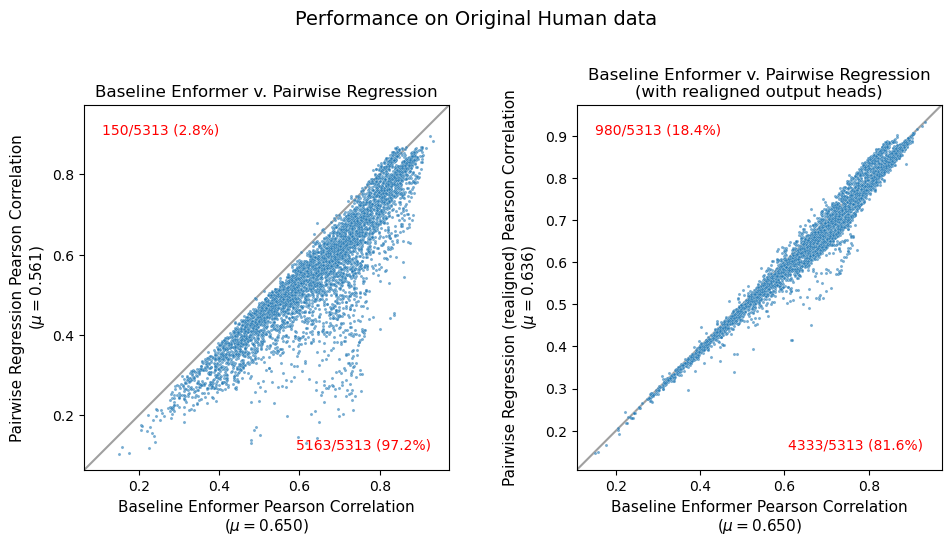

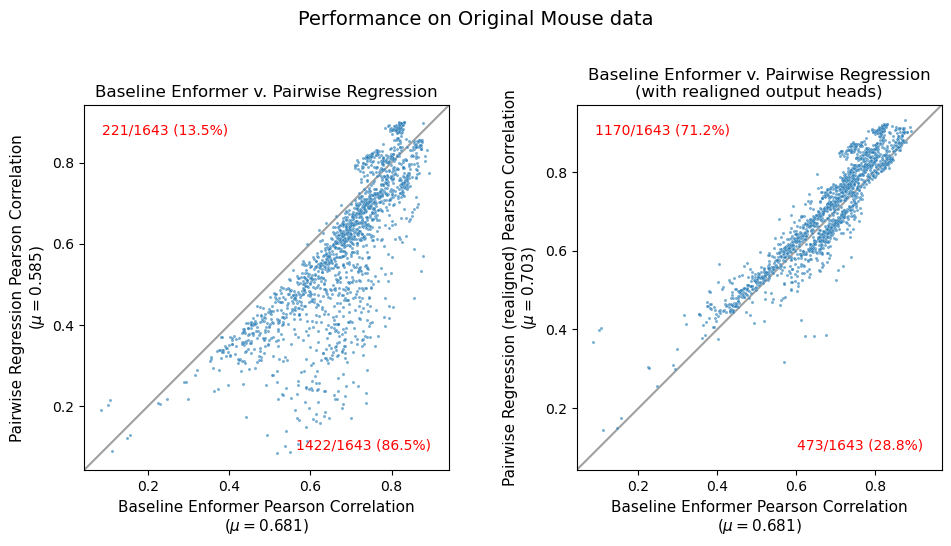

In [13]:
df = full_summary.copy()

# Define metrics and models
metrics = ["pearson_corr"]
finetuned_models = ["regression", "finetune_regression_on_enformer_data"]

# Get unique species
species_list = df["species"].unique()

model_to_name = {
    "regression": "Pairwise Regression",
    "finetune_regression_on_enformer_data": "Pairwise Regression (with realigned output heads)"    
}
species_to_name = {"mouse": "Mouse", "human": "Human"}
metric_to_name = {"pearson_corr": "Pearson Correlation"}

# Loop over species and metrics
for species in ["human", "mouse"]:
    species_df = df[df["species"] == species]
    for metric in metrics:
        fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
        for ax, model in zip(axs, finetuned_models):
            baseline_df = species_df[species_df["model"] == "baseline"].set_index("track_id")
            finetuned_df = species_df[species_df["model"] == model].set_index("track_id")

            baseline_df = baseline_df[[metric]].rename(columns={metric: "baseline"})
            finetuned_df = finetuned_df[[metric]].rename(columns={metric: model})
            merged_df = baseline_df.merge(finetuned_df, left_index=True, right_index=True).reset_index()

            sns.scatterplot(x="baseline", y=model, data=merged_df, ax=ax, alpha=0.6, s=5)

            # Add diagonal line
            lims = [
                np.min([ax.get_xlim(), ax.get_ylim()]),
                np.max([ax.get_xlim(), ax.get_ylim()])
            ]
            ax.plot(lims, lims, 'gray', alpha=0.75, zorder=0)
            ax.set_aspect("equal")
            ax.set_xlim(lims)
            ax.set_ylim(lims)

            n_above_diagonal = (merged_df[model] > merged_df["baseline"]).sum()
            n_below_diagonal = (merged_df[model] <= merged_df["baseline"]).sum()
            n_total = len(merged_df)
            pct_above_diagonal = n_above_diagonal / n_total * 100.0
            pct_below_diagonal = n_below_diagonal / n_total * 100.0

            ax.annotate(
                f"{n_above_diagonal}/{n_total} ({pct_above_diagonal:.1f}%)",
                xy=(0.05, 0.95),
                xycoords="axes fraction",
                fontsize=10,
                color="red",
                ha="left",
                va="top"
            )

            ax.annotate(
                f"{n_below_diagonal}/{n_total} ({pct_below_diagonal:.1f}%)",
                xy=(0.95, 0.05),
                xycoords="axes fraction",
                fontsize=10,
                color="red",
                ha="right",
                va="bottom"
            )

            mean_x = merged_df["baseline"].mean()
            mean_y = merged_df[model].mean()
            model_y = model_to_name[model] if "(" not in model_to_name[model] else "Pairwise Regression (realigned)"
            ax.set_xlabel(
                "Baseline Enformer Pearson Correlation" + "\n" + rf"($\mu={mean_x:.3f}$)",
                fontsize=11
            )
            ax.set_ylabel(
                f"{model_y} Pearson Correlation" + "\n" + rf"($\mu={mean_y:.3f}$)", 
                fontsize=11
            )
            
            if "(" in model_to_name[model]:
                model_prefix = f"{model_to_name[model].split('(')[0].strip()}"
                model_paranthetical = "(" + f"{model_to_name[model].split('(')[1].strip()}"
                ax.set_title(f"Baseline Enformer v. {model_prefix}" + "\n" + f"{model_paranthetical}", fontsize=12)
            else:
                ax.set_title(f"Baseline Enformer v. {model_to_name[model]}", fontsize=12)
            
        plt.suptitle(
            f"Performance on Original {species_to_name[species]} data", fontsize=14, y=1.05
        )
        plt.tight_layout()
        plt.savefig(f"figures/orig_{species}_perf.pdf", bbox_inches="tight")